In [11]:
from config_.paths import *
from config_.parameters import width_cutler

from helper.tuning import *
from helper.annotations import *
from helper.coco import *
from helper.faiss import *
from helper.lib_detectron2 import *
from helper.dataframes import *
from helper.lib_SA import visualizeSA
from helper.paths import getName,collectPaths,getImagePath,initPath,getId
from helper.common_libraries import join,shutil,Image,deepcopy

# Isolate retrieved images to collect finer masks

In [12]:
if False:
    # get list of image from image_dict
    channel = 'CH00004'
    path_file_image_dict = join(path_root_manual_annotation,channel,'image_dict.json')
    image_dict = readJson(path_file_image_dict)
    list_timestamp_jerry = readJson(path_file_image_dict)['90007']['faiss']
    
    # copy to dummy directory
    path_dir_dest = join(path_root_images_from_src,'CHjery4')
    for id in list_timestamp_jerry:
        shutil.copy(getImagePath(id),join(path_dir_dest,id+'.jpg'))
        
    # ==> collect masks 

# _LER preparation

### Resize images and store them accordingly to detectron2 requirements

In [13]:
# resize images
if False:
    path_dir_src = join(path_root_images_from_src,'CHjery4')
    path_dir_dest = '/home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/imgs'
    
    for path in collectPaths(path_dir_src):
        image = Image.open(path)
        width, height = image.size
        scaling_factor_x = width/width_cutler
        resized_image = image.resize((width_cutler,int(height/scaling_factor_x)),Image.LANCZOS)
        resized_image.save(join(path_dir_dest,getName(path)))

### Adapt GT file

In [14]:
jerry_file_GT = readJson('/home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/annotations/gt.json')
path_dir_image_resized = '/home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/imgs'
if False:

    for d in jerry_file_GT['images']:
        d['file_name'] = 'CH00004_20230318_0'+d['file_name']
        img = imreadRGB(join(path_dir_image_resized,d['file_name']))
        height,width = img.shape[:2]
        d['height']=height
        d['width']=width

    size=(width,height)
    anns = decodeMasks(jerry_file_GT['annotations'])

    for ann in anns:
        tmp =  deepcopy(ann['segmentation'])
        ann['segmentation'] = np.array(Image.fromarray(tmp).resize(size))
        ann['area'] = updateArea(ann['segmentation'])
        ann['bbox'] = updateBbox(ann['segmentation'])

    jerry_file_GT['annotations'] = encodeMasks(anns)
    writeJson('/home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/annotations/te_GT_jerry_clip.json',jerry_file_GT)

In [17]:
registerCatalog('jerry','/home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/annotations/gt.json',path_dir_image_resized)

registered: jerry
json is located at: /home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/annotations/gt.json
images are located at: /home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/imgs



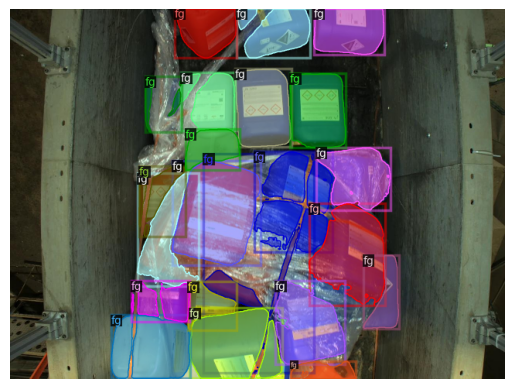

In [18]:
visualizeD2(23,'jerry')

### load manual annotations

In [19]:
# json manual annotations
path_dir_masks_man = join(path_root_manual_annotation,'CH00004','ann_images')
path_list_masks_man = collectPaths(path_dir_masks_man)

# df merged
path_file_merged_xq = join(path_root_manual_annotation,'CH00004','df_merged','merged0.csv')
idx_cat,ids_xb_cat = initCategoryIndex([], path_file_merged_xq, max_nb_instances=0)

In [20]:
# filter jerry
df_jerry = filterCat(readDf(path_file_merged_xq),90007)
df_jerry = stackDfs([filterAoI(df_jerry,0),filterAoI(df_jerry,1)])
df_jerry = filterHead(df_jerry,1)

# extract ids, q1,q3
ids_jerry = extractIds(df_jerry)
q3,q1 = np.percentile(df_jerry['area_segm'],[90,10])

df_jerry.head()

,timestamp_id,SA_id,is_head,solo,head_id,area_segm,height,width,area_bbox,AoI,...,758,759,760,761,762,763,764,765,766,767
0,CH00004_20230301_133605,0,1,1,0,100836,413,332,137116,1,...,0.010284,-0.56500,0.19310,-0.20070,-0.1425,0.3772,-0.34520,-0.6860,0.4111,-0.26220
1,CH00004_20230301_135325,0,1,1,0,53453,239,274,65486,1,...,-0.051150,0.01399,0.72800,-0.18570,0.6523,0.4766,0.02002,-0.4238,0.5366,-0.11720
6,CH00004_20230302_145913,0,1,1,0,37664,242,177,42834,1,...,0.508300,-0.47000,0.59600,0.22990,0.3894,0.6216,0.16210,-0.4553,0.7410,-0.26600
14,CH00004_20230307_150412,0,1,1,0,130532,463,444,205572,1,...,-0.220800,0.11190,0.12213,-0.41650,0.9907,0.5490,0.19850,0.1832,-0.0573,0.01332
15,CH00004_20230307_150412,1,1,1,1,56592,303,296,89688,1,...,0.085500,0.33230,0.32470,-0.11096,0.3481,0.3103,0.46040,-0.5684,-0.2852,0.24770


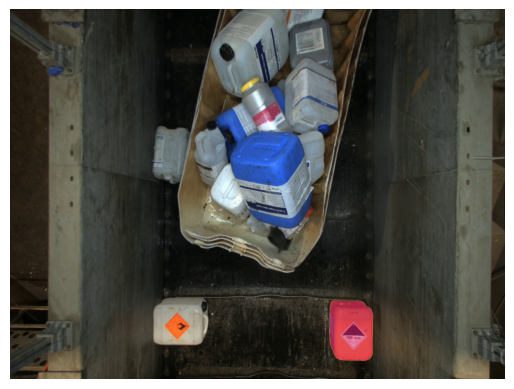

'CH00004_20230516_161722'

In [22]:
# visualize
n_viz = 19

masks = decodeMasks(readJson(join(path_dir_masks_man,ids_jerry[0][n_viz]+'.json')))
masks = filterMasks(masks,ids_jerry[1][n_viz])
visualizeSA([],masks)

ids_jerry[0][n_viz]

### collect initial annotations

In [23]:
path_dir_masks = join(path_root_masks_from_images,'32','CHjery4')
path_list_masks = collectPaths(path_dir_masks)

path_dir_emb = join(path_root_embeddings_from_masks,'32','CHjery4','df_merged')
path_list_emb = collectPaths(path_dir_emb)

In [24]:
# keep AoI==0, AoI==1, head, and q1<=area<=q3

temp = []
for path in path_list_emb:
    df = readDf(path)
    df = stackDfs([filterAoI(df,0),filterAoI(df,1)])
    df = filterHead(df,1)
    df = df[np.logical_and(q1<=df['area_segm'],df['area_segm']<=q3)]
    temp.append(df)

df_AoI_head = stackDfs(temp)
xb = extractEmbeddings(df_AoI_head)
ids = extractIds(df_AoI_head)
ids.append(extractValues(df_AoI_head,'category_id'))

In [25]:
out_of = 2
k_NN = 3

# search k-NN on category index
D,I = idx_cat.search(xb,k_NN)
cat_vote = filterIds(ids_xb_cat,I)[2]

# is_a_jerrycan if k-out-of-k-NN
is_a_jerrycan = [k for k,item in enumerate(cat_vote) if item.count(90007)>=out_of]

print('ann/image:')
len(is_a_jerrycan)/len(path_list_masks)

ann/image:


2.844092963202066

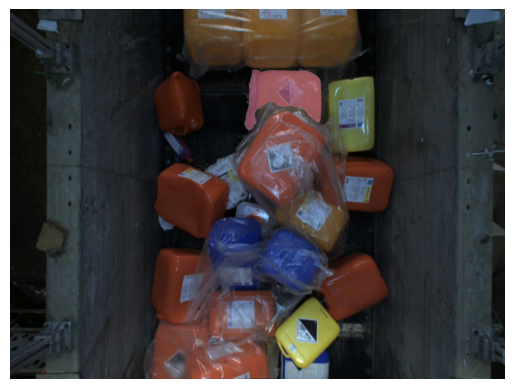

'CH00004_20230309_082126'

In [43]:
import time

# Seed the random number generator with the current time
random.seed(time.time())

rdm = random.randint(0,4000)
n_viz = is_a_jerrycan[rdm]

masks = decodeMasks(readJson(join(path_dir_masks,ids[0][n_viz]+'.json')))
masks = filterMasks(masks,ids[1][n_viz])
visualizeSA([],masks)

ids[0][n_viz]

### create train coco anns

In [44]:
img_base = sorted([getId(item) for item in collectPaths(path_dir_image_resized) if '20230318' in item])
img_retrieved = sorted([getId(item) for item in collectPaths(path_dir_image_resized) if '20230318' not in item])

dict_img_id = {item:k for k,item in enumerate(img_base + img_retrieved)}

In [49]:
path_file_pgt = '/home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/annotations/pgt.json'

if not exists(path_file_pgt):
    images = []
    for id in dict_img_id.keys():
        file_name = id + '.jpg'
        tmp = imreadRGB(join(path_dir_image_resized,file_name))
        height,width = tmp.shape[:2]
        images.append({
            'file_name':file_name,
            'height':height,
            'width':width,
            'id':dict_img_id[id]
        })
        
    pgt = initCocoAnnotations(path_file_pgt)
    pgt['images'] = images
    pgt['categories'] = jerry_file_GT['categories']
    writeJson(path_file_pgt, pgt)
    
else: pgt = readJson(path_file_pgt)

In [50]:
ids_init = filterIds(ids,is_a_jerrycan)
timestamp_init = sortedUnique(ids_init[0])

anns_init = []
for item in timestamp_init:
    tmp = [ann for id,ann in zip(ids_init[0],ids_init[1]) if id==item]
    anns_init.append(tmp)


In [51]:
pgt['annotations']=[]

for id,sa_id in zip(timestamp_init,anns_init):
    masks = readJson(join(path_dir_masks,id+'.json'))
    masks = filterMasks(masks,sa_id)
    for mask in masks:
        tmp ={
            'segmentation':mask['segmentation'],
            'area':mask['area'],
            'iscrowd':0,
            'bbox':mask['bbox'],
            'category_id':1,
            'id':-1,
            'image_id': dict_img_id[id]
        }
        
        pgt['annotations']+=[tmp]
    

In [52]:
size=(width,height)
anns = []

for k,ann in enumerate(pgt['annotations']):
    if k%500 ==0:print(k,len(pgt['annotations']))
    
    tmp = decodeMasks([ann])[0]
    resized = deepcopy(tmp)
    resized['segmentation'] = np.array(Image.fromarray(tmp['segmentation']).resize(size))
    resized['area'] = updateArea(resized['segmentation'])
    resized['bbox'] = updateBbox(resized['segmentation'])
    resized['id'] = k
    anns += encodeMasks([resized])
    
pgt['annotations'] = anns    
writeJson(path_file_pgt,pgt)

0 8811
500 8811
1000 8811
1500 8811
2000 8811
2500 8811
3000 8811
3500 8811
4000 8811
4500 8811
5000 8811
5500 8811
6000 8811
6500 8811
7000 8811
7500 8811
8000 8811
8500 8811


In [53]:
registerCatalog('pgt',path_file_pgt,path_dir_image_resized)

registered: pgt
json is located at: /home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/annotations/pgt.json
images are located at: /home/dkhatanassia/PDM/00_Deliverable/tests/test_CutLER/jerry_3000/imgs



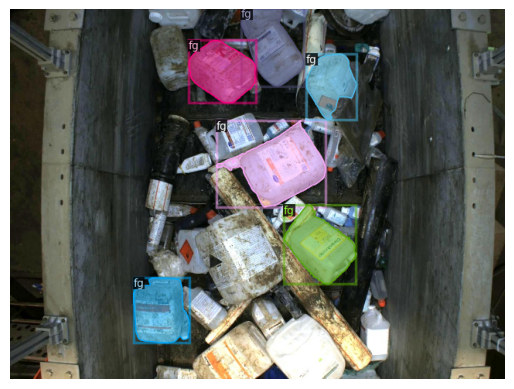

In [56]:
visualizeD2(368,'pgt')